In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import json
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
import tensorflow as tf
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from matplotlib import pyplot as plt
import cv2


import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

import segmentation_models as sm

In [12]:
# Load image and mask paths
def load_image_paths(base_dir, scene_id):
    #before_image1 = os.path.join(base_dir, f'{scene_id}_change-0.png')
    before_image1 = base_dir + '/' + scene_id + '_change-0.png'
    #after_image1 = os.path.join(base_dir, f'{scene_id}_change-1.png')
    after_image1 = base_dir + '/' + scene_id + '_change-1.png'
    #mask = os.path.join(base_dir, f'{scene_id}_mask.png')
    mask = base_dir + '/' + scene_id + '_mask.png'
    return before_image1, after_image1, mask

def get_image_pairs_and_masks(base_dir, scene_ids):
    image_pairs = []
    masks = []
    
    
    for scene_id in scene_ids:
        before_image1, after_image1, mask = load_image_paths(base_dir, scene_id)
        image_pairs.append((before_image1, after_image1))
        masks.append(mask)
        
    return image_pairs, masks

In [13]:
# Data generator
class ChangeDetectionDataset(tf.keras.utils.Sequence):
    def __init__(self, image_pairs = None, masks = None, batch_size=1, image_size=(256, 256), shuffle=True):
        self.json_file = open('utils/synthetic_anno.json')
        self.coco = json.load(self.json_file) 
        self.process_images()
        if(image_pairs is None and masks is None):
            self.image_pairs, self.masks = self.get_image_pairs_and_masks('data/renders_multicam_diff_1')
        else:
            self.image_pairs = image_pairs
            self.masks = masks
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_pairs))
        self.on_epoch_end()
        
    def get_image_pairs_and_masks(self, base_dir):
        image_pairs = []
        masks = []
        
        scene_ids = [item['scene'] for item in self.coco['images']]
        
        for scene_id in scene_ids:
            before_image1, after_image1, mask = load_image_paths(base_dir, scene_id)
            if not os.path.exists(mask):
                continue
            image_pairs.append((before_image1, after_image1))
            masks.append(mask)
            
            
        return image_pairs, masks
    
    def __len__(self):
        return int(np.ceil(len(self.image_pairs) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_pairs = [self.image_pairs[i] for i in indices]
        batch_masks = [self.masks[i] for i in indices]
        
        #X1, X2, y = self.__data_generation(batch_image_pairs, batch_masks)
        X, y = self.__data_generation(batch_image_pairs, batch_masks)
        #return [X1, X2], y
        return tf.convert_to_tensor(X), tf.convert_to_tensor(y)
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_pairs))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    # def __data_generation(self, batch_image_pairs, batch_masks):
    #     X1 = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
    #     X2 = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
    #     y = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)  # 3 channels for color-coded mask
        
    #     for i, (img_paths, mask_path) in enumerate(zip(batch_image_pairs, batch_masks)):
    #         before_img = img_to_array(load_img(img_paths[0], target_size=self.image_size)) / 255.0
    #         after_img = img_to_array(load_img(img_paths[1], target_size=self.image_size)) / 255.0
    #         mask = img_to_array(load_img(mask_path, target_size=self.image_size)) / 255.0
            
    #         X1[i, :, :, :] = before_img
    #         X2[i, :, :, :] = after_img
    #         y[i, :, :, :] = mask
        
    #     return X1, X2, y
    
    def __data_generation(self, batch_image_pairs, batch_masks):
        X = np.zeros((self.batch_size, *self.image_size, 6), dtype=np.float32)  # 6 channels for concatenated images
        y = np.zeros((self.batch_size, *self.image_size, 4), dtype=np.float32)  # 3 channels for color-coded mask
        
        for i, (img_paths, mask_path) in enumerate(zip(batch_image_pairs, batch_masks)):
            before_img = img_to_array(load_img(img_paths[0], target_size=self.image_size)) / 255.0
            after_img = img_to_array(load_img(img_paths[1], target_size=self.image_size)) / 255.0
            #mask = img_to_array(load_img(mask_path, target_size=self.image_size)) / 255.0
            mask = img_to_array(load_img(mask_path, target_size=self.image_size))

            mask = self.rgb_to_onehot(mask)
            
            X[i, :, :, :3] = before_img
            X[i, :, :, 3:] = after_img
            y[i, :, :, :] = mask
        
        return X, y
    
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image

    def rgb_to_onehot(self,rgb_image):
        onehot_image = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 4), dtype=np.float32)
        onehot_image[(rgb_image == [0, 0, 0]).all(axis=-1)] = [1, 0, 0, 0]     # Background
        onehot_image[(rgb_image == [255, 0, 0]).all(axis=-1)] = [0, 1, 0, 0]   # Red (Taken)
        onehot_image[(rgb_image == [0, 255, 0]).all(axis=-1)] = [0, 0, 1, 0]   # Green (Added)
        onehot_image[(rgb_image == [0, 0, 255]).all(axis=-1)] = [0, 0, 0, 1]   # Blue (Shifted)
        return onehot_image
    
    def onehot_to_rgb(self, onehot_mask):
        rgb_image = np.zeros((onehot_mask.shape[0], onehot_mask.shape[1], 3), dtype=np.float32)
        rgb_image[onehot_mask[:, :, 0] == 1] = [0, 0, 0]   # Background
        rgb_image[onehot_mask[:, :, 1] == 1] = [255, 0, 0] # Red (Taken)
        rgb_image[onehot_mask[:, :, 2] == 1] = [0, 255, 0] # Green (Added)
        rgb_image[onehot_mask[:, :, 3] == 1] = [0, 0, 255] # Blue (Shifted)
        return rgb_image

In [14]:
dataset = ChangeDetectionDataset()

print(dataset.images)

{0: {'id': 0, 'license': 1, 'scene': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-0', 'width': 1280, 'height': 720, 'randommats1': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-0_change-0-randommats.png', 'randommats2': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-0_change-1-randommats.png', 'depth1': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-0_change-0-depth0001.exr', 'depth2': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-0_change-1-depth0001.exr', 'image1': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-0_change-0.png', 'image2': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-0_change-1.png'}, 1: {'id': 1, 'license': 1, 'scene': '00b25e61c54740e78f4649c4435eb41f/cmps.ca.0000_00b25e61c54740e78f4649c4435eb41f_cam-1', 'w

In [15]:
# Example usage with provided scene_ids
base_dir = 'data/renders_multicam_diff1'
images_arr = dataset.images

# Split dataset
image_pairs_train, image_pairs_test, masks_train, masks_test = train_test_split(
    dataset.image_pairs, dataset.masks, test_size=0.2, random_state=42
)

image_pairs_train, image_pairs_validation, masks_train, masks_validation = train_test_split(
    image_pairs_train, masks_train, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = ChangeDetectionDataset(image_pairs_train, masks_train)
validation_dataset = ChangeDetectionDataset(image_pairs_validation, masks_validation)
test_dataset = ChangeDetectionDataset(image_pairs_test, masks_test, shuffle=False)

In [16]:
model = sm.Unet('resnet34', input_shape=(256, 256, 6), classes=4, activation='sigmoid', encoder_weights=None)

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score, sm.metrics.precision, sm.metrics.recall, 'accuracy'],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(train_dataset, batch_size=1, epochs=50, validation_data=validation_dataset)


# def unet_encoder(input_tensor, name_prefix):
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv1_1')(input_tensor)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv1_2')(conv1)
#     conv1 = BatchNormalization()(conv1)
#     pool1 = MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(conv1)

#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv2_1')(pool1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv2_2')(conv2)
#     conv2 = BatchNormalization()(conv2)
#     pool2 = MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(conv2)

#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv3_1')(pool2)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv3_2')(conv3)
#     conv3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D((2, 2), name=f'{name_prefix}_pool3')(conv3)

#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv4_1')(pool3)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv4_2')(conv4)
#     conv4 = BatchNormalization()(conv4)
#     pool4 = MaxPooling2D((2, 2), name=f'{name_prefix}_pool4')(conv4)

#     conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv5_1')(pool4)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv5_2')(conv5)
#     conv5 = BatchNormalization()(conv5)

#     return conv1, conv2, conv3, conv4, conv5

# def unet_decoder(conv1_b, conv1_a, conv2_b, conv2_a, conv3_b, conv3_a, conv4_b, conv4_a, center_b, center_a, num_classes):
#     merge1 = concatenate([center_b, center_a], axis=-1)
#     up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', activation='relu')(merge1)
#     merge1 = concatenate([up1, conv4_b, conv4_a], axis=-1)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge1)
#     conv6 = BatchNormalization()(conv6)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
#     conv6 = BatchNormalization()(conv6)

#     up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv6)
#     merge2 = concatenate([up2, conv3_b, conv3_a], axis=-1)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge2)
#     conv7 = BatchNormalization()(conv7)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
#     conv7 = BatchNormalization()(conv7)

#     up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv7)
#     merge3 = concatenate([up3, conv2_b, conv2_a], axis=-1)
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge3)
#     conv8 = BatchNormalization()(conv8)
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
#     conv8 = BatchNormalization()(conv8)

#     up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(conv8)
#     merge4 = concatenate([up4, conv1_b, conv1_a], axis=-1)
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
#     conv9 = BatchNormalization()(conv9)
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
#     conv9 = BatchNormalization()(conv9)

#     output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

#     return output

# def siamese_unet(input_size=(256, 256, 6), num_classes=4):
#     inputs = Input(shape=input_size)

#     # Split the input into before and after images
#     before_image = tf.slice(inputs, [0, 0, 0, 0], [-1, -1, -1, 3])
#     after_image = tf.slice(inputs, [0, 0, 0, 3], [-1, -1, -1, 3])

#     # Encoder for before image
#     conv1_b, conv2_b, conv3_b, conv4_b, center_b = unet_encoder(before_image, 'before')
    
#     # Encoder for after image
#     conv1_a, conv2_a, conv3_a, conv4_a, center_a = unet_encoder(after_image, 'after')

#     # Decoder
#     output = unet_decoder(conv1_b, conv1_a, conv2_b, conv2_a, conv3_b, conv3_a, conv4_b, conv4_a, center_b, center_a, num_classes)

#     model = Model(inputs=inputs, outputs=output)
#     return model

# # Define class weights based on your dataset
# class_weights = np.array([0.5, 2.0, 2.0, 2.0])  # Adjust as needed

# def weighted_categorical_crossentropy(weights):
#     def loss(y_true, y_pred):
#         y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
#         y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

#         # Compute the weighted cross entropy
#         ce = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
#         weight_map = tf.reduce_sum(weights * y_true, axis=-1)
#         loss = ce * weight_map
#         return tf.reduce_mean(loss)
#     return loss

# # Compile the model
# model = siamese_unet(input_size=(256, 256, 6), num_classes=4)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer, loss=weighted_categorical_crossentropy(class_weights), metrics=['accuracy'])



Epoch 1/50
37/37 [==============================] - 12s 149ms/step - loss: 1.1629 - iou_score: 0.2013 - f1-score: 0.2289 - precision: 0.2503 - recall: 0.5194 - accuracy: 0.8922 - val_loss: 1100.4796 - val_iou_score: 0.2452 - val_f1-score: 0.2479 - val_precision: 0.3457 - val_recall: 0.3253 - val_accuracy: 0.9815
Epoch 2/50
37/37 [==============================] - 4s 107ms/step - loss: 0.8536 - iou_score: 0.2413 - f1-score: 0.2545 - precision: 0.2528 - recall: 0.4173 - accuracy: 0.9795 - val_loss: 0.8565 - val_iou_score: 0.2374 - val_f1-score: 0.2494 - val_precision: 0.2501 - val_recall: 0.3639 - val_accuracy: 0.9815
Epoch 3/50
37/37 [==============================] - 4s 109ms/step - loss: 0.8048 - iou_score: 0.2539 - f1-score: 0.2704 - precision: 0.2661 - recall: 0.4181 - accuracy: 0.9795 - val_loss: 1.0154 - val_iou_score: 0.2446 - val_f1-score: 0.2531 - val_precision: 0.2508 - val_recall: 0.3468 - val_accuracy: 0.9815
Epoch 4/50
37/37 [==============================] - 4s 105ms/step 

In [17]:
#model.fit(train_dataset, validation_data=validation_dataset, epochs=50)

In [18]:
score = model.evaluate(test_dataset)

12/12 [==============================] - 1s 85ms/step - loss: 0.7321 - iou_score: 0.2939 - f1-score: 0.3188 - precision: 0.4301 - recall: 0.4598 - accuracy: 0.9933


In [19]:
model.predict(test_dataset)

12/12 [==============================] - 2s 87ms/step


array([[[[9.91338849e-01, 2.80916318e-03, 4.03207581e-04,
          3.06373026e-04],
         [9.99109566e-01, 1.48771651e-04, 3.89642855e-06,
          1.05364325e-05],
         [9.99012828e-01, 1.82531337e-04, 7.35206277e-06,
          1.46098973e-05],
         ...,
         [9.98444140e-01, 3.06768168e-04, 1.28426645e-05,
          1.68999013e-05],
         [9.98216331e-01, 1.91134561e-04, 8.31158286e-06,
          1.30930512e-05],
         [9.81351912e-01, 1.90473266e-03, 1.61773307e-04,
          5.36523119e-04]],

        [[9.98801470e-01, 1.53839239e-04, 1.11100226e-05,
          9.04954322e-06],
         [9.99985456e-01, 2.87778539e-06, 3.72962141e-08,
          3.29879555e-08],
         [9.99982238e-01, 5.23458721e-06, 1.14892373e-07,
          7.82945904e-08],
         ...,
         [9.99953270e-01, 1.46440034e-05, 3.59245945e-07,
          3.65531577e-07],
         [9.99957919e-01, 6.12223494e-06, 1.31872810e-07,
          1.71241226e-07],
         [9.98662233e-01, 1.5159238

12/12 [==============================] - 1s 82ms/step


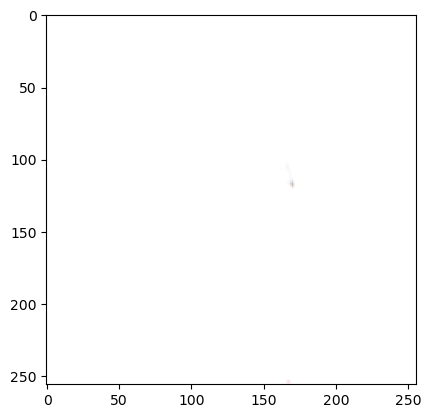

In [20]:
predictions = model.predict(test_dataset)
plt.imshow(predictions[2])

In [21]:

def visualize_predictions(model, dataset, batch_index=0):
    # Get a batch of data
    X, y_true = dataset[batch_index]
    
    summed_mask = np.sum(y_true, axis=3)
    #cv2.imshow("Summed Mask", summed_mask)
    print('SHAPES: ', X.shape, y_true.shape)
    X1, X2 = np.split(X, 2, axis=-1)  # Split concatenated images back into two images
    y_pred = model.predict(X)

    # Convert predictions and ground truth to class labels
    y_true_labels = np.argmax(y_true, axis=-1, keepdims=True)
    print('Y_TRUE_LABELS: ', y_true_labels.shape)
    y_pred_labels = np.argmax(y_pred, axis=-1, keepdims=True)
    print('Y_PRED_LABELS: ', y_pred_labels.shape)

    y_true_rgb = np.array([dataset.onehot_to_rgb(np.eye(4)[y_true_labels[i].squeeze()]) for i in range(y_true_labels.shape[0])])
    print('Y_TRUE_RGB: ', y_true_rgb.shape)
    y_pred_rgb = np.array([dataset.onehot_to_rgb(np.eye(4)[y_pred_labels[i].squeeze()]) for i in range(y_pred_labels.shape[0])])

    #y_true_rgb = np.array([onehot_to_rgb(y) for y in y_true_labels])
    
    #y_pred_rgb = np.array([onehot_to_rgb(y) for y in y_pred_labels])

    # Function to plot images and masks
    def plot_comparison(before_img, after_img, true_mask, pred_mask, index=0):
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        axs[0].imshow(before_img[index])
        axs[0].set_title('Before Image')
        axs[0].axis('off')

        axs[1].imshow(after_img[index])
        axs[1].set_title('After Image')
        axs[1].axis('off')

        axs[2].imshow(true_mask[index])
        axs[2].set_title('Ground Truth Mask')
        axs[2].axis('off')

        axs[3].imshow(pred_mask[index])
        axs[3].set_title('Predicted Mask')
        axs[3].axis('off')

        plt.show()

    # Plot the results for the first image in the batch
    
    plot_comparison(X1, X2, y_true_rgb, y_pred_rgb)



SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


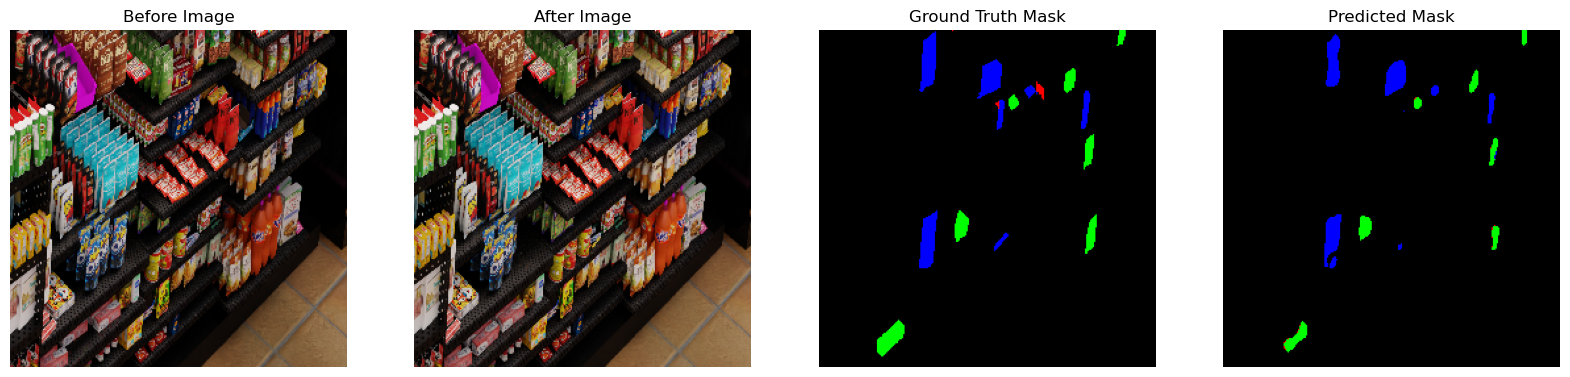

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


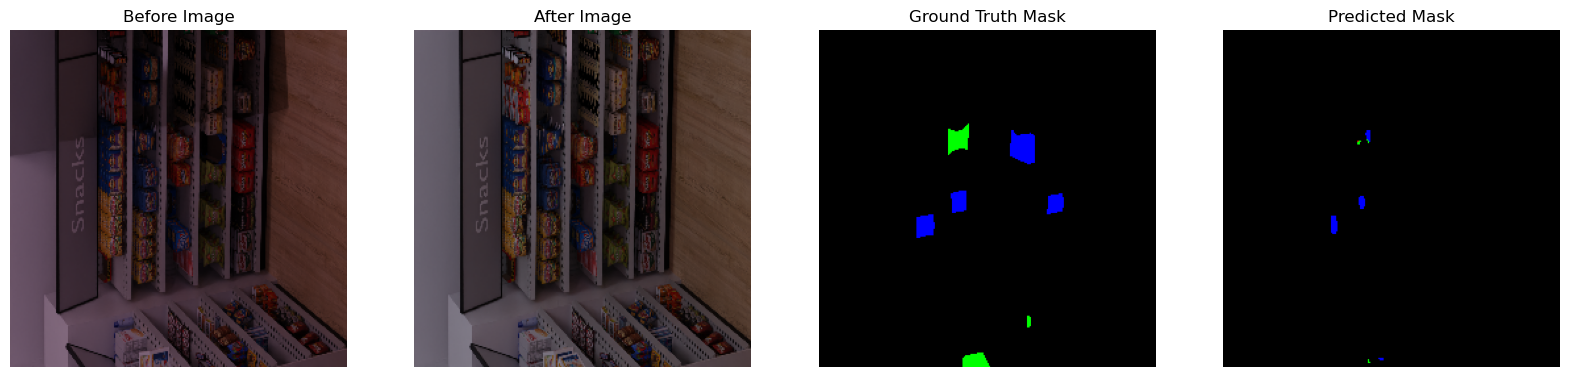

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


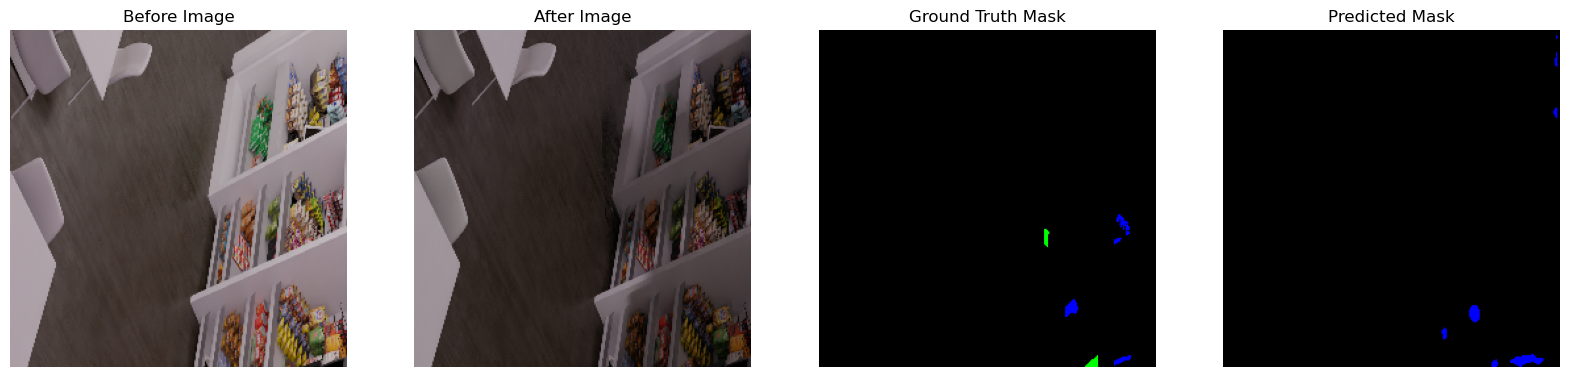

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 23ms/step
Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


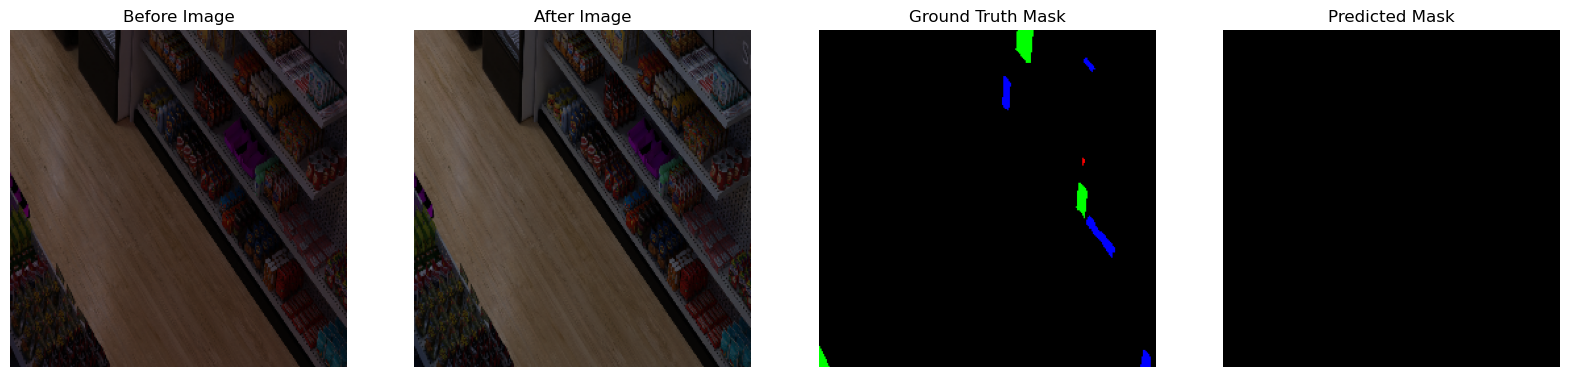

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


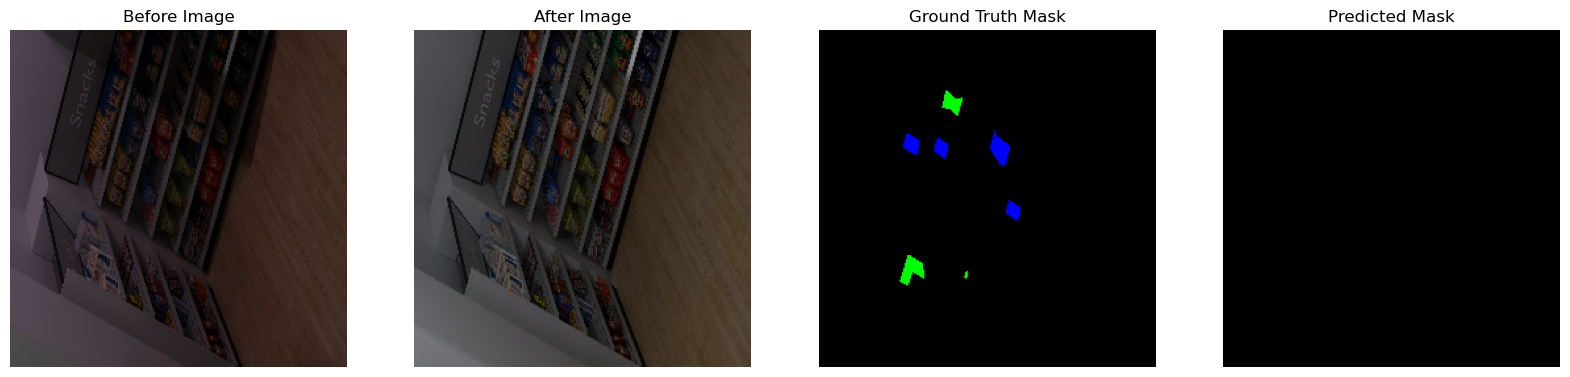

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


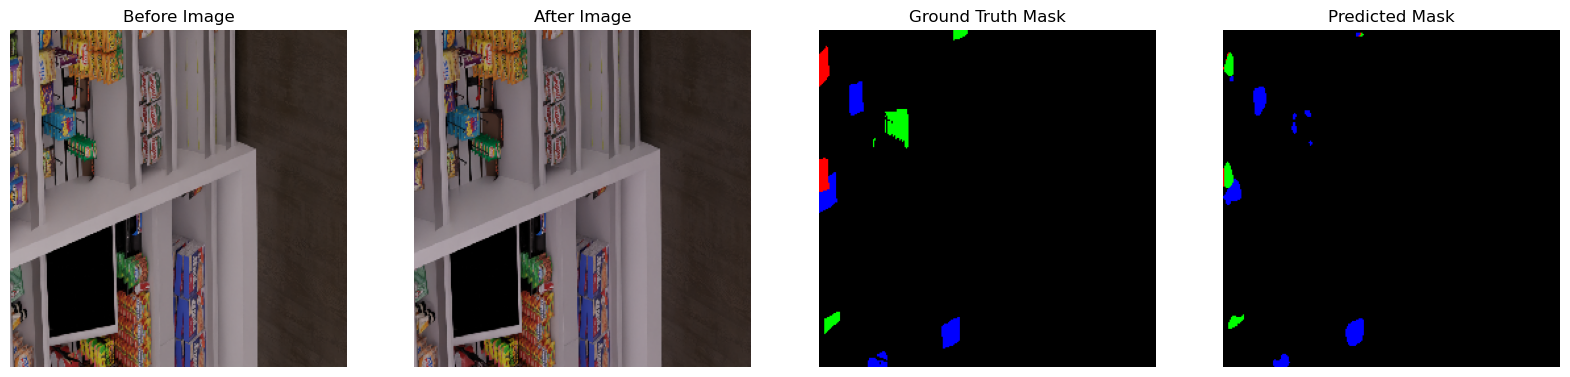

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


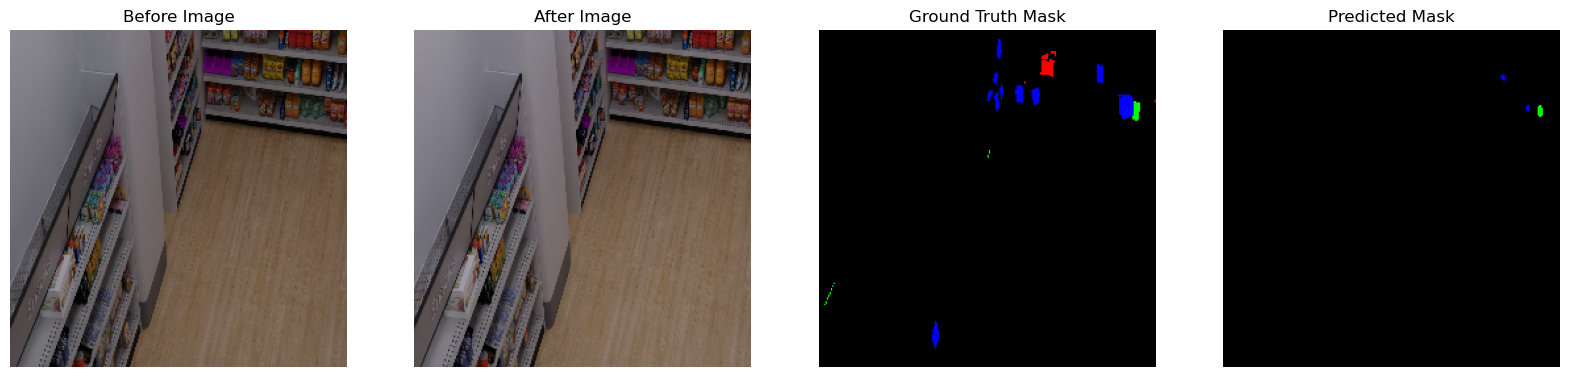

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 29ms/step
Y_TRUE_LABELS:  (1, 256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


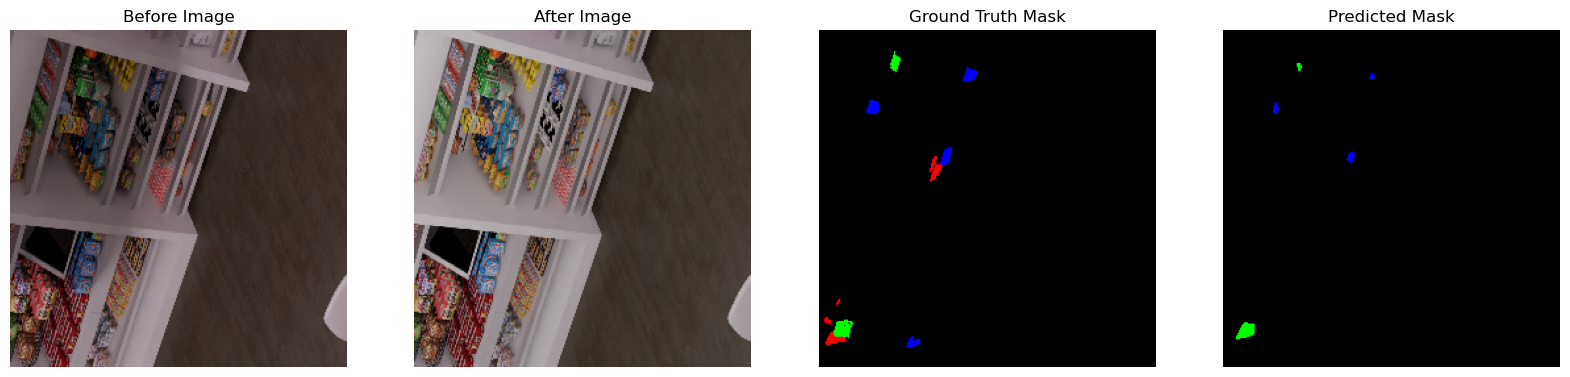

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


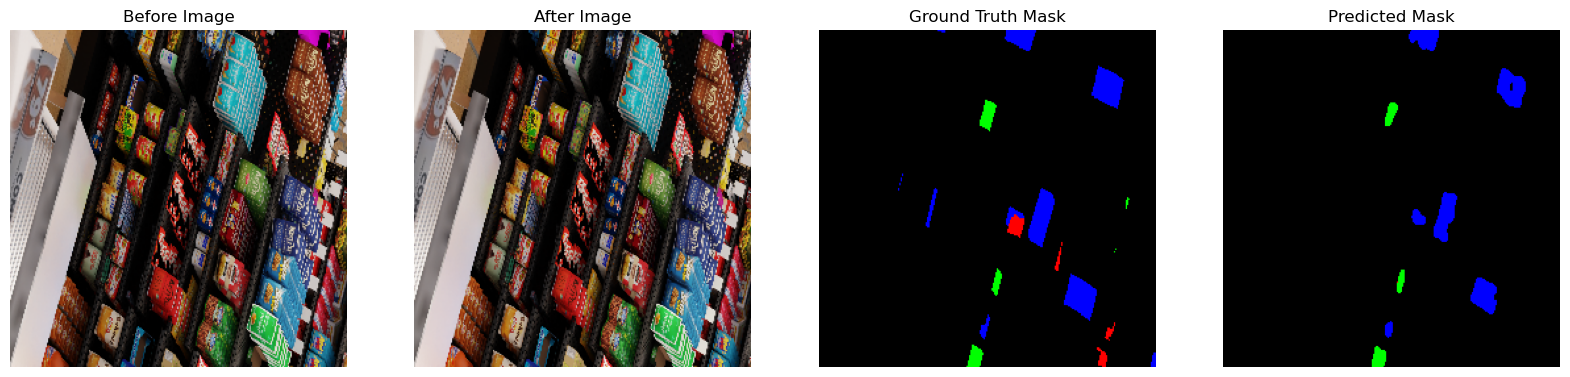

SHAPES:  (1, 256, 256, 6) (1, 256, 256, 4)
1/1 [==============================] - 0s 29ms/step
Y_TRUE_LABELS:  (1, 256, 256, 1)
Y_PRED_LABELS:  (1, 256, 256, 1)
Y_TRUE_RGB:  (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


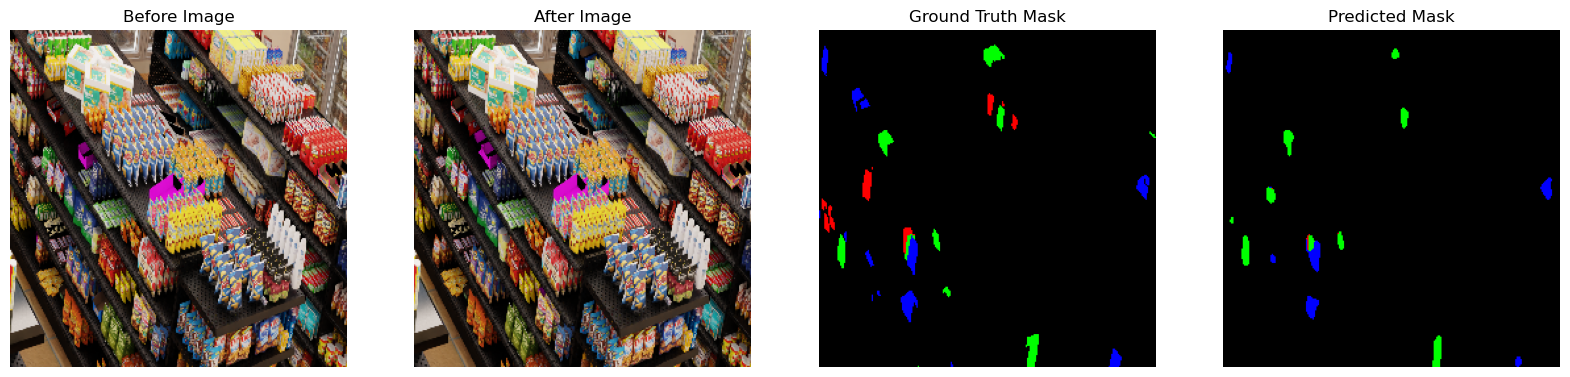

In [26]:
for i in range(10):
    visualize_predictions(model, train_dataset, batch_index=i)
#visualize_predictions(model, train_dataset, batch_index=8)

In [23]:
# def unet_model(input_size=(256, 256, 3)):
#     inputs1 = Input(input_size)
#     inputs2 = Input(input_size)
    
#     def unet_encoder(inputs):
#         conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#         conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#         pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
#         conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#         conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#         pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
#         conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#         conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
        
#         return conv1, conv2, conv3
    
#     enc1 = unet_encoder(inputs1)
#     enc2 = unet_encoder(inputs2)
    
#     def unet_decoder(enc1, enc2):
#         merge = concatenate([enc1[2], enc2[2]])
        
#         conv4 = Conv2D(512, 3, activation='relu', padding='same')(merge)
#         conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
        
#         up5 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4), enc1[1], enc2[1]])
#         conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
#         conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
        
#         up6 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5), enc1[0], enc2[0]])
#         conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
#         conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
        
#         conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv6)
#         conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
        
#         outputs = Conv2D(3, 1, activation='softmax')(conv7)  # 3 channels for color-coded output
        
#         return outputs
    
#     outputs = unet_decoder(enc1, enc2)
#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#     return model

# model = unet_model()
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [24]:
#model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

In [25]:
# class SingleStream(tf.keras.Model):
#   """ Constructs a Resnet-Deeplabv3 segmentation model with additional streams for depth inputs
#   """
#   def __init__(self, num_classes=4, pretrained=True, use_rgb=True, use_depth=False):
#     """
#     @param num_classes (int): Number of classes including background
#     @param pretrained (bool): Whether to load Coco pretrained weights into Resnet backbone
#     @param use_depth (bool): Whether to increase number of input channels to allow for depth
#     """
#     super(SingleStream, self).__init__()
#     self.use_depth = use_depth
#     self.use_rgb = use_rgb

#     if self.use_depth and self.use_rgb:
#       num_channels = 8  # Training with both rgb and depth
#     elif not self.use_depth and self.use_rgb:
#       num_channels = 6  # Training with only rgb
#     elif self.use_depth and not self.use_rgb:
#       num_channels = 2  # Training with only depth
#     else:
#       print("Need RGB and/or depth input params set.")
#       raise Exception

#     self.model = ResNet50(weights="imagenet" if pretrained else None, include_top=False)  # Load pre-trained weights

#     self.conv1 = tf.keras.layers.Conv2D(num_channels, 64, kernel_size=(7, 7), strides=(2, 2), padding="same")
#     self.conv1_relu = tf.keras.layers.ReLU()
#     self.conv1_norm = tf.keras.layers.BatchNormalization(num_channels)

#   def call(self, inputs):
#     img1, img2, depth1, depth2 = inputs

#     if self.use_depth and self.use_rgb:
#       input_cat = tf.concat([img1, depth1, img2, depth2], axis=1)
#     elif not self.use_depth and self.use_rgb:
#       input_cat = tf.concat([img1, img2], axis=1)
#     elif self.use_depth and not self.use_rgb:
#       input_cat = tf.concat([depth1, depth2], axis=1)
#     else:
#       print("Need RGB and/or depth input.")
#       raise Exception

#     x = self.conv1(input_cat)
#     x = self.conv1_norm(self.conv1_relu(x))

#     x = self.model(x)

#     return x

# class ChangeDetectionModel(tf.keras.Model):
#   def __init__(self, configuration):
#     super(ChangeDetectionModel, self).__init__()
#     self.configuration = configuration

#     self.loss_names = ['segmentation']
#     self.network_names = ['changedetection']
#     self.num_classes = configuration["num_classes"]

#     # Define the SingleStream model
#     self.netchangedetection = SingleStream(
#         4, True, configuration["rgb"]
#     )

#     # Check number of parameters in model (requires counting manually)
#     total_params = sum(
#         tf.reduce_prod(p.shape) for p in self.netchangedetection.trainable_variables
#     )
#     print("Number total params:", total_params)

#     # Move the model to GPU if available
#     self.netchangedetection = self.netchangedetection.to_tensorboard()

#     # Buffers for storing predictions and labels during validation (if applicable)
#     if configuration["dataset_name"] in ["syntheticpairs", "simplesyntheticpairs"]:
#       w, h = configuration["spatial_resolution"]
#       if configuration["mode"] == 'val':
#         self.val_predictions = tf.zeros((949, h, w))
#         self.val_labels = tf.zeros((949, h, w))
#       elif configuration["mode"] == 'test':
#         self.val_predictions = tf.zeros((955, h, w))
#         self.val_labels = tf.zeros((955, h, w))
#       self.val_count = 0
#     else:
#       print("Unknown dataset name in changedetection_model.py")

#   def compile(self, learning_rate=None):
#     if self.is_train:  # Only during training
#       # Define loss function
#       loss_weights = tf.constant(
#           [0.0035252888617000786, 0.33161259399877635, 0.3316452266650099, 0.3332168904745137]
#       )
#       self.criterion_loss = CategoricalCrossentropy(weight=loss_weights)

#       # Define optimizer
#       self.optimizer = SGD(learning_rate=learning_rate or self.configuration["lr"])

#   def call(self, inputs):
#     """Forward pass of the model."""
#     img1, img2, depth1, depth2 = inputs
#     self.output = self.netchangedetection(inputs)
#     return self.output

#   def train_step(self, data):
#     """Training step with automatic loss calculation and gradient update."""
#     img1, img2, depth1, depth2, label = data
#     with tf.GradientTape() as tape:
#       predictions = self(img1, img2, depth1, depth2)
#       loss_segmentation = self.criterion_loss(label, predictions)
#       total_loss = loss_segmentation

#     gradients = tape.gradient(total_loss, self.trainable_variables)
#     self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

#     # Return metrics dictionary (can be customized)
#     return {"loss": total_loss, "segmentation_loss": loss_segmentation}

#   def set_input(self, inputs, mode='train'):
#     """Process and store input data."""
#     img1, img2, label, bboxes, classes, scene, depth1, depth2 = inputs
#     self.input = (img1, img2, depth1, depth2)
#     self.label = tf.cast(label, tf.int64)
#     self.name = scene

#   def test_step(self, data, save_images=False, output_path='/app/synthetic_data_baselines/predictions'):
#     """Testing/evaluation step."""
#     img1, img2, depth1, depth2, label = data
#     predictions = self.call(img1, img2, depth1, depth2)

#     # Update validation buffers (if applicable)
#     self.val_labels = tf.concat([self.val_labels, tf.expand_dims(self.label, axis=0)], axis=0)
#     out = tf.math.argmax(predictions, axis=-1)
#     self.val_predictions = tf.concat([self.val_predictions, tf.expand_dims(out, axis=0)], axis=0)

#     # Jaccard score calculation (can be replaced with other metrics)
#     iou = tf.keras.metrics.Jaccard(num_classes=self.num_classes, average=None)(
#         self.val_labels, self.val_predictions
#     )

#     # Save predictions (example code, adapt to your needs)
#     if save_images:
#       palette = [0, 0, 0, 159, 4, 22, 98, 190, 48, 122, 130, 188] * 64
#       img1 = tf.image.convert_image_dtype(tf.squeeze(out, axis=0), tf.uint8)
#       img1 = tf.expand_dims(img1, axis=-1)
#       img1 = tf.repeat(img1, 3, axis=-1)
#       img1 = tf.cast(img1, tf.uint8)
#       img1 = tf.gather(palette, img1)
#       img1 = tf.squeeze(img1, axis=0)
#       tf.keras.preprocessing.image.save_img(
#           os.path.join(output_path, self.name[0] + "_pred.png"), img1
#       )
#       print("Saving ", os.path.join(output_path, self.name[0] + "_pred.png"))

#     self.input, self.label, self.output = None, None, None
#     self.val_count += 1

#     # Return metrics dictionary (can be customized)
#     return {"iou": iou}

#   def post_epoch_callback(self, epoch, visualizer=None):
#     """Calculate and report IoU metrics after each epoch."""
#     # Flatten predictions and labels for IoU calculation
#     iou = tf.reduce_mean(self.val_labels == self.val_predictions, axis=-1)
#     metrics = {"iou": iou}

#     if visualizer:
#       visualizer.plot_current_validation_metrics(epoch, metrics)
#     print(iou)
#     print(tf.reduce_mean(iou))

#     # Re-initialize validation buffers
#     w, h = self.configuration["spatial_resolution"]
#     self.val_predictions = tf.zeros((949, h, w))
#     self.val_labels = tf.zeros((949, h, w))
#     self.val_count = 0

#     # Return mean IoU and mean IoU without background class (can be customized)
#     return tf.reduce_mean(iou), tf.reduce_mean(iou[1:])

